In [1]:
#pip install lime

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import nltk
from nltk.corpus import stopwords

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix,f1_score

## 1 - Dataset




<div class="alert alert-block alert-warning">
    We will use the <code>half-moons</code> dataset, which you already know how to handle, to enable result visualization, and the <a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">UCI ML Breast Cancer Wisconsin (Diagnostic)</a> dataset, which has more attributes.
</div>


In [4]:
breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

feature_names = breast_cancer.feature_names
target_names = breast_cancer.target_names

## 2 - Linear Model Training

<div class="alert alert-block alert-warning">
We will learn the classification task using a logistic regression model.
</div>

In [11]:
logreg = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix

array([[53,  3],
       [ 3, 84]])

- Accuracy: (TP + TN) / (TP + TN + FP + FN)
- Precision: TP / (TP + FP)
- Recall (or Sensitivity): TP / (TP + FN)
- F1-Score: 2 * (Precision * Recall) / (Precision + Recall)

In [11]:
f1_score(y_test, y_pred, average='binary')

0.9726775956284154

<AxesSubplot:title={'center':'Feature importance'}>

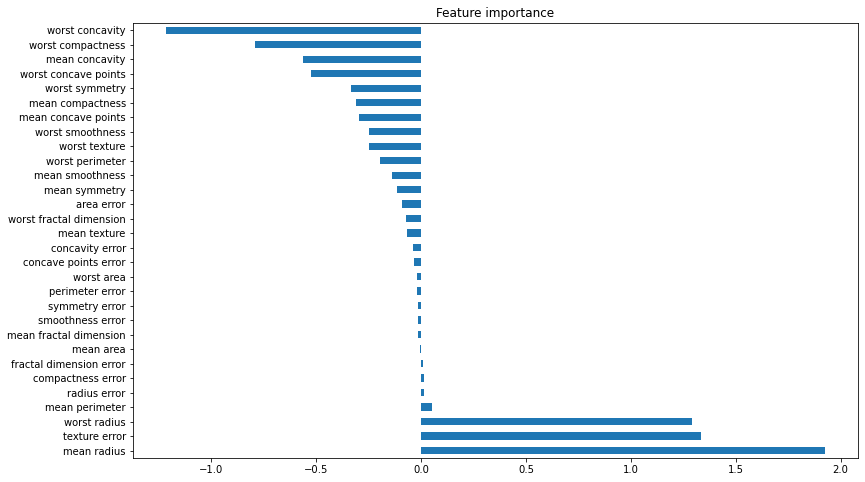

In [12]:
import pandas as pd
coefs = logreg.coef_[0]
plt.figure(figsize=(13,8))
plt.title("Feature importance")
pd.Series(coefs, index=feature_names).nlargest(coefs.size).plot(kind='barh')

#### For testset

<AxesSubplot:title={'center':'Feature importance'}>

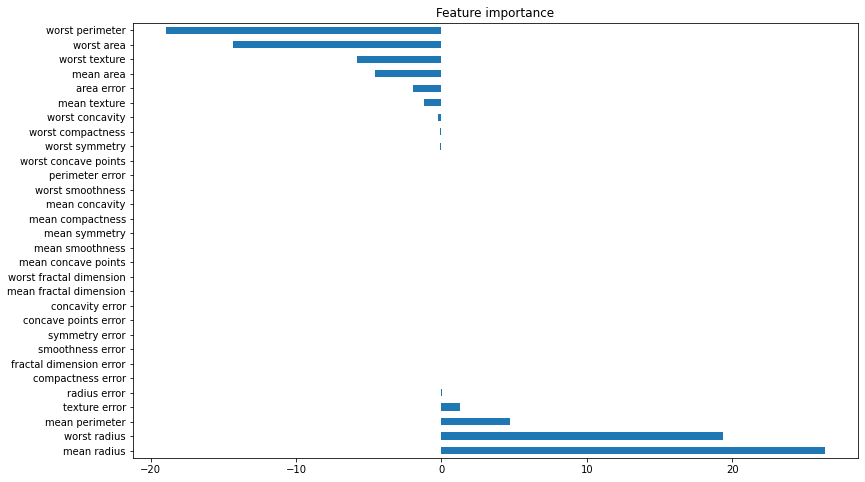

In [13]:
importances_test_example = X_test[0] * coefs
# importances_test_example_normalized = importances_test_example / importances_test_example.sum()
plt.figure(figsize=(13,8))
plt.title("Feature importance")
pd.Series(importances_test_example, index=feature_names).nlargest(importances_test_example.size).plot(kind='barh')

## 3 - Explanation with LIME

<div class="alert alert-block alert-warning">
We will examine an explanation provided by LIME.
</div>

Explanation for the first exemple of the testset

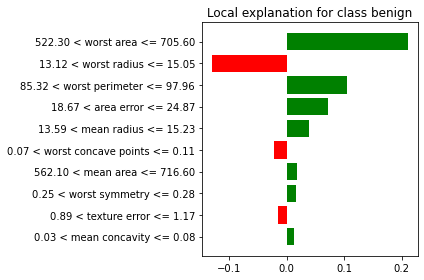

In [14]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_test,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=[],
    mode='classification')

exp = explainer.explain_instance(X_test[0], logreg.predict_proba, num_features=10)

exp.as_pyplot_figure()
plt.tight_layout()

To classify the example 0 from the test set as 'benign' based on the explanations provided by LIME:

- To predict example 0 as 'benign,' the 'worst_area' attribute with values lower than 495.95 has a positive impact on this prediction. This means that when the 'worst_area' value is low, it's more likely that the example is classified as 'benign.' In other words, tumors with a lower 'worst_area' value are more likely to be benign.

- On the other hand, the 'mean_radius' attribute with a value lower than 11.64 has a negative impact on the prediction of the 'benign' class. This means that when the 'mean_radius' value is low, it strengthens the prediction that the example is not 'benign' (i.e., malignant).

- The attributes 'worst_area,' 'worst_perimeter,' 'area_error,' 'worst_texture,' 'mean_area,' and 'mean_perimeter' play a positive role in predicting the 'benign' class. Their lower values contribute to strengthening the 'benign' prediction. This indicates that when these features have low values, the model is more likely to predict 'benign.'

- On the other hand, the attributes 'mean_radius,' 'worst_radius,' 'mean_texture,' and 'texture_error' have a negative impact on the prediction of the 'benign' class. Their high values strengthen the negative prediction of 'benign.' In other words, when these features have high values, the model is more likely to predict a class other than 'benign.'

Comparison with the next sample of the testset

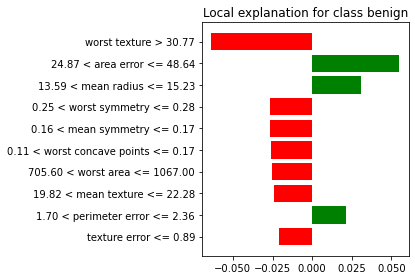

In [15]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_test,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=[],
    mode='classification')

exp = explainer.explain_instance(X_test[1], logreg.predict_proba, num_features=10)

exp.as_pyplot_figure()
plt.tight_layout()

## 4 - Experiments

<div class="alert alert-block alert-info">
In this section, we will conduct experiments to investigate the behavior of LIME. The objective is to examine the stability of LIME explanations concerning the choice of the instance of interest and the classifier. We will define a protocol to conduct these experiments.
</div>

### 4.1 - Stability

To study the stability of the LIME algorithm, we will focus on two aspects:
- Stability concerning the returned features.
- Stability concerning the returned values for a given feature.

In [16]:
sample = 14
nb_iter = 30
num_features = 10

feat_names = {}
dico_values = {}

for _ in tqdm(range(nb_iter)):

    explainer = LimeTabularExplainer(X_test,
        feature_names=feature_names,
        class_names=target_names,
        categorical_features=[],
        mode='classification')

    exp = explainer.explain_instance(X_test[sample], logreg.predict_proba, num_features=num_features)
    
    names = np.array(exp.as_list())[:,0]
    values = np.array(exp.as_list())[:,1]
    values = values.astype(float).tolist()
    
    for i_feat , name in enumerate(names):
        if name in feat_names.keys():
            feat_names[name] += 1
        else:
            feat_names[name] = 1
        if name in dico_values.keys():
            dico_values[name].append(values[i_feat])
        else: dico_values[name] = [values[i_feat]]

100%|███████████████████████████████████████████| 30/30 [06:54<00:00, 13.82s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

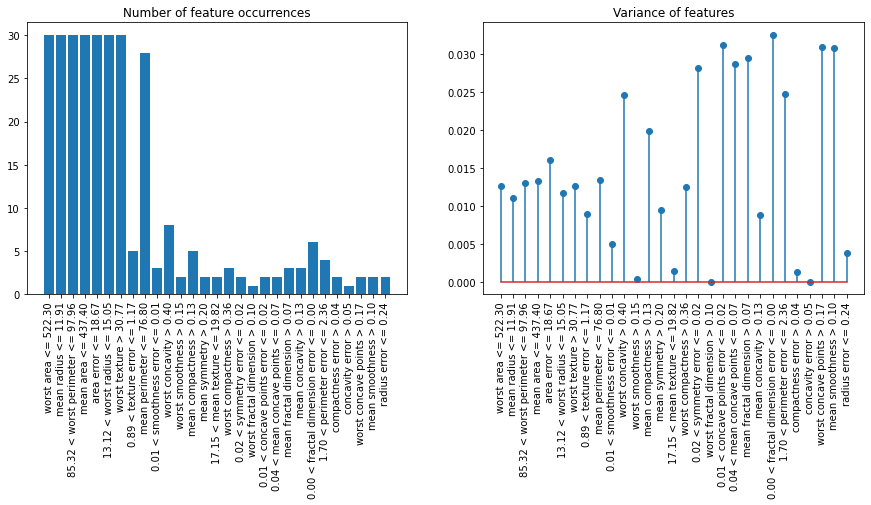

In [18]:
names = list(feat_names.keys())
counts = list(feat_names.values())

variances = []
for name in dico_values.keys():
    variances.append(np.std(dico_values[name]))
    
    
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.bar(names,counts)
plt.title("Number of feature occurrences")
plt.xticks(rotation=90)

plt.subplot(122)
plt.stem(names,variances)
plt.title("Variance of features")
plt.xticks(rotation=90)
plt.show

### 4.2 - Prediction Stability Study

Using the explanation provided by LIME, we aim to validate the accuracy of this explanation by altering the attribute identified as the most significant by LIME. If this alteration results in a change in the predicted class, it suggests that LIME's explanation is consistent and accurate in highlighting the importance of that attribute. In other words, LIME's explanation is validated if the modification of the key attribute genuinely influences the model's prediction.

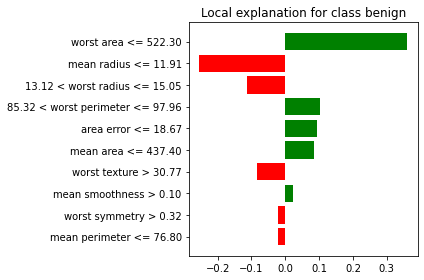

Attempt to change the class by altering the 'worst area' attribute
original exemple :  [0]
Exemple after the change of feature :  [1]


In [26]:
sample = 14
exp = explainer.explain_instance(X_test[sample], logreg.predict_proba, num_features=num_features)
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

print("Attempt to change the class by altering the 'worst area' attribute")
sample_copy = copy.deepcopy(X_test[sample])

feat_indice2 = np.where(feature_names == 'worst area')[0][0]

sample_copy[feat_indice2] = -X_test[sample][feat_indice2]

print("original exemple : ",logreg.predict([X_test[sample]]))
print("Exemple after the change of feature : ",logreg.predict([sample_copy]))

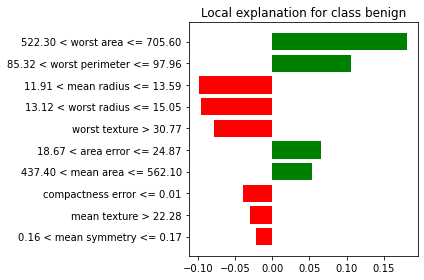

Attempt to change the class by altering the 'mean radius' attribute
original exemple :  [1]
Exemple after the change of feature :  [1]


In [27]:
sample = 96
exp = explainer.explain_instance(X_test[sample], logreg.predict_proba, num_features=num_features)
exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

print("Attempt to change the class by altering the 'area error' attribute")
sample_copy = copy.deepcopy(X_test[sample])

feat_indice2 = np.where(feature_names == 'area error')[0][0]

sample_copy[feat_indice2] = -X_test[sample][feat_indice2]

print("original exemple : ",logreg.predict([X_test[sample]]))
print("Exemple after the change of feature : ",logreg.predict([sample_copy]))

### 4.3 - Model Comparison

In [28]:
def give_explications(model,data,feature_names,target_names,sample):
    
    explainer = LimeTabularExplainer(data,
    feature_names=feature_names,
    class_names=target_names,
    categorical_features=[],
    mode='classification')

    exp = explainer.explain_instance(data[sample], model.predict_proba, num_features=10)
    
    return exp 

In [29]:
# fitting 
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

svm = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm.fit(X_train,y_train)

# explanations
exp_logreg = give_explications(logreg,X_test,feature_names,target_names,96)
exp_mlp = give_explications(mlp,X_test,feature_names,target_names,96)
exp_svm = give_explications(svm,X_test,feature_names,target_names,96)

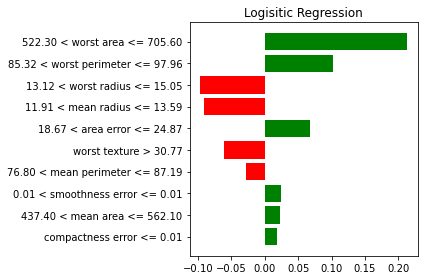

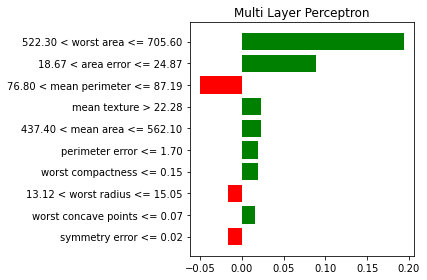

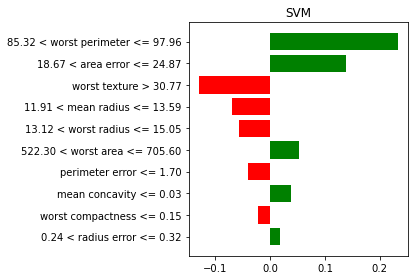

In [30]:

exp_logreg.as_pyplot_figure()
plt.title("Logisitic Regression")
plt.tight_layout()
plt.show()

exp_mlp.as_pyplot_figure()
plt.title("Multi Layer Perceptron")
plt.tight_layout()
plt.show()

exp_svm.as_pyplot_figure()
plt.title("SVM")
plt.tight_layout()
plt.show()

In [31]:
names_logreg = np.array(exp_logreg.as_list())[:,0]
names_mlp = np.array(exp_mlp.as_list())[:,0]
names_svm = np.array(exp_svm.as_list())[:,0]

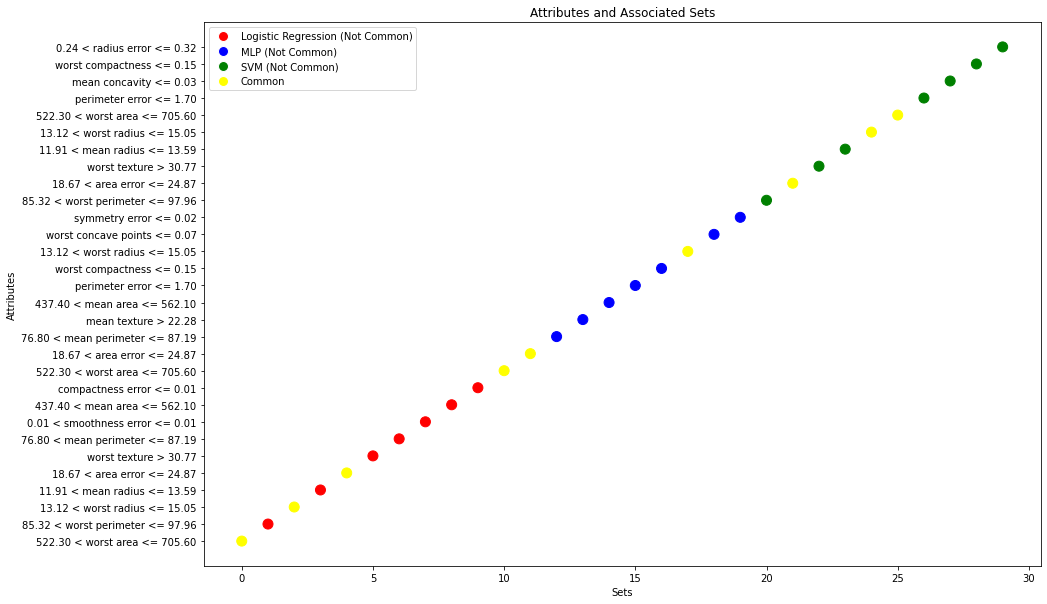

In [32]:
import matplotlib.pyplot as plt

# Create lists to store attributes, the sets they belong to, and whether they are common
attributes = []
sets = []
common = []

# Associate each attribute with its set and determine if they are common
for name in names_logreg:
    attributes.append(name)
    sets.append("Logistic Regression")
    if name in names_mlp and name in names_svm:
        common.append("Common")
    else:
        common.append("Not Common")

for name in names_mlp:
    attributes.append(name)
    sets.append("MLP")
    if name in names_logreg and name in names_svm:
        common.append("Common")
    else:
        common.append("Not Common")

for name in names_svm:
    attributes.append(name)
    sets.append("SVM")
    if name in names_logreg and name in names_mlp:
        common.append("Common")
    else:
        common.append("Not Common")

# Create a color for each set
colors = {'Logistic Regression': 'red', 'MLP': 'blue', 'SVM': 'green'}

# Create a color for common attributes
common_color = 'yellow'

# Create a list of colors based on the common condition
point_colors = [common_color if status == "Common" else colors[set_name] for set_name, status in zip(sets, common)]

# Plot the points
plt.figure(figsize=(15, 10))
plt.scatter(range(len(attributes)), range(len(attributes)), c=point_colors, marker='o', s=100)

# Label the axes
plt.yticks(range(len(attributes)), attributes)
plt.ylabel('Attributes')
plt.xlabel('Sets')

# Create a legend
legend_elements = []
for set_name, color in colors.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f'{set_name} (Not Common)', markerfacecolor=color, markersize=10))
legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label='Common', markerfacecolor=common_color, markersize=10))
plt.legend(handles=legend_elements)

# Display the scatter plot
plt.title("Attributes and Associated Sets")
plt.show()


It's worth noting that most of the returned attributes are shared by all three models, even though each model also generates unique attributes. This observation suggests that we can leverage this convergence by aggregating the results from all three models to obtain a more comprehensive and reliable explanation for the user. This approach becomes particularly useful when uncertainties persist regarding an explanation because the second or third model can either confirm or refute the base model's explanation, thereby bolstering confidence in the interpretation of the results.

## 5 - Textual Data

<div class="alert alert-block alert-warning">
    We will train a random forest classification model on the <code>fetch_20newsgroups</code> data and then use LIME to obtain explanations for the classification of examples.
</div>

Using the [documentation for the fetch_20newsgroups dataset](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py), we will train a binary text classification model using a random forest.

In [35]:
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

newsgroups_data = fetch_20newsgroups(subset='all', categories=['alt.atheism', 'sci.space'])
data = newsgroups_data.data
target = newsgroups_data.target

In [36]:
categories = [
    "rec.sport.baseball",
    "sci.space"
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names()

    if verbose:
        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return vectorizer,data_train['data'], data_test['data'] , X_train, X_test, y_train, y_test, feature_names, target_names

<div class = "alert alert-block alert-info">
We will use LIME to obtain explanations for the predictions made on some examples.
</div>

In [37]:
vecto,data_train,data_test,X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(verbose=True)

1190 documents - 2.04MB (training set)
791 documents - 1.34MB (test set)
2 categories
vectorize training done in 0.221s at 9.267MB/s
n_samples: 1190, n_features: 5214
vectorize testing done in 0.119s at 11.279MB/s
n_samples: 791, n_features: 5214


In [38]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

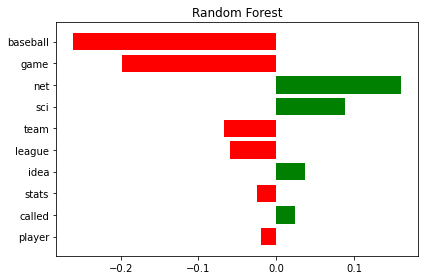

In [39]:
exp_rf_96 = give_explications(rf_classifier,X_test,feature_names,target_names,sample=96)

exp_rf_96.as_pyplot_figure()
plt.title("Random Forest")
plt.tight_layout()
plt.show()

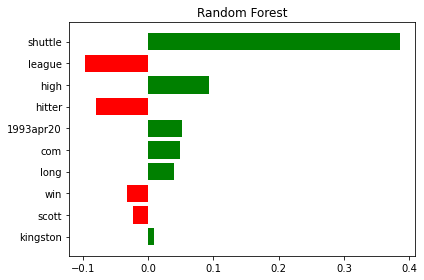

In [40]:
exp_rf_1 = give_explications(rf_classifier,X_test,feature_names,target_names,sample=1)

exp_rf_1.as_pyplot_figure()
plt.title("Random Forest")
plt.tight_layout()
plt.show()

The analysis of the explanation provided by LIME for example 96 reveals that to correctly predict the class of membership, some keywords such as 'net,' 'sci,' and 'idea' are the most decisive. These terms are strongly associated with the domain of space. On the other hand, less relevant but crucial features for predicting the opposite class are directly related to the vocabulary of sports and baseball, including 'baseball,' 'game,' 'team,' and 'league.'

## 6 - Implémentation de LIME

<div class="alert alert-block alert-info">
    On textual data, we will implement a rudimentary version of LIME
</div>

### Data Generation Procedure for Z (Textual Data)

1. **Data Perturbation**: Randomly remove words from the text of interest.

2. **Binary Representation**: Represent each perturbed example using a binary representation where 1 indicates that a word was retained, and 0 indicates that a word was removed.

3. **Prediction Calculation**: Calculate the probability (prob) that the perturbed example belongs to class 1 (e.g., "spam" in a spam detection problem) based on the modified text.

4. **Example Weight Calculation**: Compute the weight (πz) of the generated example as follows:
   - weight = 1 - (Number of words removed / Total number of words initially present)

This procedure outlines how we generate perturbed examples from textual data, calculate their class probabilities, and assign weights based on the number of words removed relative to the original text.

In [42]:
ind_sample = 96
sample = data_test[ind_sample]
predicted_label = rf_classifier.predict(X_test[ind_sample])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform([sample])
feature_names = np.array(vectorizer.get_feature_names())

# supprimer les tokens de type 'int'
feature_names = feature_names[66:]

In [46]:
def LIME_DIY(ind_sample,sample,predicted_label,vecto,range_disabling=np.arange(50,150),nb_data=100,with_stop_words=True):
    
    copy_sample = copy.deepcopy(sample)
    
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([sample])
    feature_names = np.array(vectorizer.get_feature_names())
    # supprimer les tokens de type 'int'
    feature_names = feature_names[66:]

    if with_stop_words == False:
        feature_names = np.array([word for word in feature_names if word.lower() not in stopwords.words('english')])

        
    data_perturbed = []
    weights = []
    N = len(feature_names)
    probas_f = []
    
    for _ in range(nb_data):
    
        # choisis le nombre de mots à desctiver
        words_to_disable = np.random.choice((range_disabling),1,replace=False)

        # choisir les mots à desactiver
        indices = np.random.choice(len(feature_names), words_to_disable, replace=False)
        perturbed_sample = np.ones((len(feature_names)))
        perturbed_sample[indices] = 0

        # construction des données bruitées
        data_perturbed.append(perturbed_sample)

        # construction du vecteur de poids 
        weights.append(float(words_to_disable / N))

        # Liste de mots à supprimer
        mots_a_supprimer = feature_names[indices]

        # Divisez le paragraphe en mots en utilisant l'espace comme séparateur
        mots_copy_sample = copy_sample.split()

        # Parcourez les mots et conservez uniquement ceux qui ne sont pas dans la liste de mots à supprimer
        mots_restants = [mot for mot in mots_copy_sample if mot.lower() not in mots_a_supprimer]

        # Rejoignez les mots restants pour former un nouveau paragraphe
        copy_sample2 = ' '.join(mots_restants)
        copy_sample2_vect = vecto.transform([copy_sample2])
        probas = np.array(rf_classifier.predict_proba(copy_sample2_vect)[0])

        probas_f.append(probas[predicted_label][0])
    
    
    return np.array(data_perturbed) , np.array(weights) , np.array(probas_f)

def display_importances(importances1,words1,importances2,words2):

    # Créez une figure
    plt.figure(figsize=(13,5))

    plt.subplot(121)
    # Créez un diagramme à barres pour les importances
    plt.barh(words1, importances1, color='green')

    # Ajoutez des étiquettes et un titre
    plt.xlabel('Importance')
    plt.title('Importance des mots (LIME DIY)')

    # Affichez la figure
    plt.tight_layout()
    
    plt.subplot(122)
    
    plt.barh(words2, importances2, color='red')

    # Ajoutez des étiquettes et un titre
    plt.xlabel('Importance')
    plt.title('Importance des mots (LIME DIY)')

    # Affichez la figure
    plt.tight_layout()
    
    plt.show()


#### version avec stop words

In [47]:
range_disabling = np.arange(50,100)
nb_data=300

data_perturbed , weights , probas_f = LIME_DIY(ind_sample,
                                              sample,predicted_label,
                                              vecto,range_disabling=range_disabling,nb_data=nb_data,
                                               with_stop_words=True)

In [48]:
reglin = LinearRegression()
reglin.fit(data_perturbed,probas_f)

predictions = reglin.predict(data_perturbed)

mse = mean_squared_error(probas_f, predictions)
r2 = r2_score(probas_f, predictions)

print("Mean Squared Error:", mse)
print("R-squared (R²):", r2)

Mean Squared Error: 3.0999626100227543e-05
R-squared (R²): 0.9851074711806316


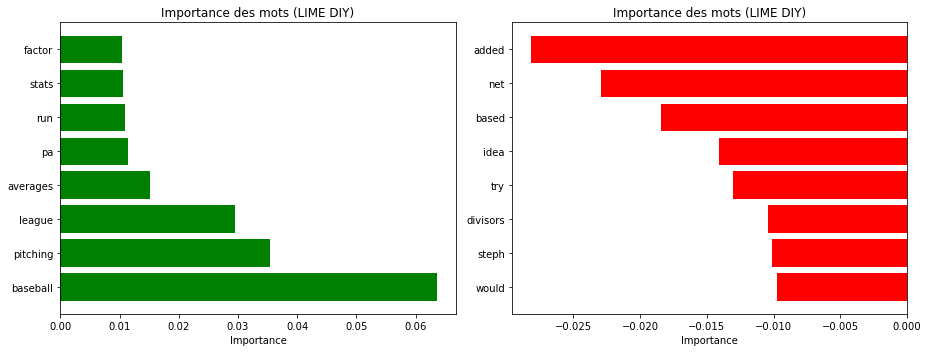

In [51]:
coefs = reglin.coef_
nb_features = 8

# Utilisez enumerate pour obtenir à la fois les éléments et leurs indices
enumerated_coefs = list(enumerate(coefs))

# Trier la liste en fonction des éléments (en ordre décroissant)
sorted_coefs = sorted(enumerated_coefs, key=lambda x: x[1], reverse=True)

# Prendre les 10 premiers éléments (les 10 plus grandes valeurs) avec leurs indices
most_importante = sorted_coefs[:nb_features]

# Extraire uniquement les valeurs (éléments) et les indices
valeurs_most = [valeur for index, valeur in most_importante]
indices_most = [index for index, valeur in most_importante]

less_importante = sorted_coefs[-nb_features:]

valeurs_less = [valeur for index, valeur in less_importante]
indices_less = [index for index, valeur in less_importante]

display_importances(valeurs_most , feature_names[indices_most],valeurs_less , feature_names[indices_less])

#### version sans stop words

In [52]:
range_disabling = np.arange(50,100)
nb_data=300

data_perturbed , weights , probas_f = LIME_DIY(ind_sample,
                                              sample,predicted_label,
                                              vecto,range_disabling=range_disabling,nb_data=nb_data,
                                               with_stop_words=False)

reglin = LinearRegression()
reglin.fit(data_perturbed,probas_f)

predictions = reglin.predict(data_perturbed)

mse = mean_squared_error(probas_f, predictions)
r2 = r2_score(probas_f, predictions)

print("Mean Squared Error:", mse)
print("R-squared (R²):", r2)

Mean Squared Error: 7.24833411848602e-05
R-squared (R²): 0.9719801479073599


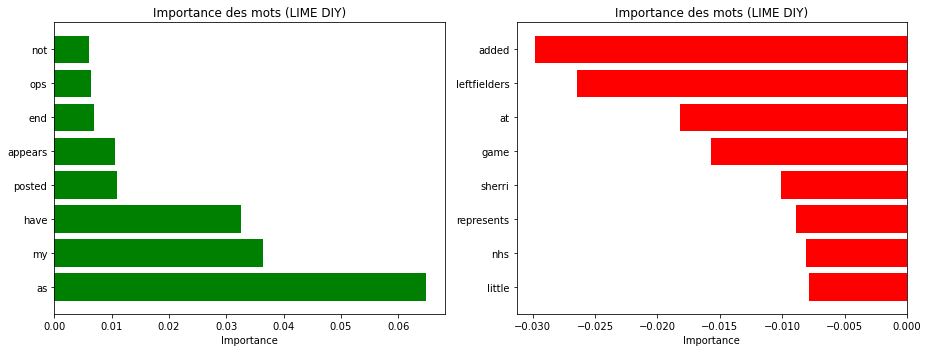

In [53]:
coefs = reglin.coef_
nb_features = 8

# Utilisez enumerate pour obtenir à la fois les éléments et leurs indices
enumerated_coefs = list(enumerate(coefs))

# Trier la liste en fonction des éléments (en ordre décroissant)
sorted_coefs = sorted(enumerated_coefs, key=lambda x: x[1], reverse=True)

# Prendre les 10 premiers éléments (les 10 plus grandes valeurs) avec leurs indices
most_importante = sorted_coefs[:nb_features]

# Extraire uniquement les valeurs (éléments) et les indices
valeurs_most = [valeur for index, valeur in most_importante]
indices_most = [index for index, valeur in most_importante]

less_importante = sorted_coefs[-nb_features:]

valeurs_less = [valeur for index, valeur in less_importante]
indices_less = [index for index, valeur in less_importante]

display_importances(valeurs_most , feature_names[indices_most],valeurs_less , feature_names[indices_less])

The LIME_DIY simplification approach can offer pedagogical and conceptual benefits, but it encounters limitations in terms of performance and scalability compared to the full version of LIME. The simplified DIY version can be adapted for specific use cases and conceptual demonstrations, but it lacks the robustness of the full LIME version, which was developed to handle a broader range of scenarios.

Data preparation before generating perturbed examples, such as token selection (removing stop words, stemming, etc.), can enhance the quality of explanations. Reducing the feature space's dimensionality by eliminating unnecessary words or tokens can help obtain more meaningful explanations and reduce noise.

Moreover, the proximity measure used for selecting perturbed examples is indeed a critical component of LIME. The proximity measure employed in LIME_DIY has limitations: while it may be easy to implement, it may not accurately represent true proximity, especially in high-dimensional spaces.

In summary, LIME_DIY can be an excellent resource for understanding the underlying concepts of LIME. However, for real-world use cases and high-performance applications, the full version of LIME, possibly with enhancements such as data preparation, is often necessary.